In [2]:
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
# import pylandau as pland
# import ROOT
import sys
import scipy.ndimage as ndimage
import numpy.ma as ma
from functions_MuonsNSAMP1 import *

def gaussian(x, a, mean, sigma, y_move):
    return a * np.exp(-((x - mean)**2 / (2 * sigma**2))) - y_move

# def gaussian(x, a, mean, sigma):
#     return a * np.exp(-((x - mean)**2 / (2 * sigma**2))) 

def diffution_curve(z, alpha, beta):
    return np.sqrt(np.abs(alpha * np.log(1 - (beta * z))))
    
from reportlab.pdfgen import canvas
from reportlab.lib.pagesizes import A4, letter
from reportlab.lib.utils import ImageReader

In [3]:
plt.rcParams.update({
    "image.origin": "lower",
    "image.aspect": 1,
    #"text.usetex": True,
    "grid.alpha": .5,
    "axes.linewidth":2,
    "lines.linewidth" : 1,
    "font.size":    15.0,
    "xaxis.labellocation": 'right',  # alignment of the xaxis label: {left, right, center}
    "yaxis.labellocation": 'top',  # alignment of the yaxis label: {bottom, top, center}
    "xtick.top":           True ,  # draw ticks on the top side
    "xtick.major.size":    8    ,# major tick size in points
    "xtick.minor.size":    4      ,# minor tick size in points
    "xtick.direction":     'in',
    "xtick.minor.visible": True,
    "ytick.right":           True ,  # draw ticks on the top side
    "ytick.major.size":    8    ,# major tick size in points
    "ytick.minor.size":    4      ,# minor tick size in points
    "ytick.direction":     'in',
    "ytick.minor.visible": True,
    "ytick.major.width":   2   , # major tick width in points
    "ytick.minor.width":   1 ,
    "xtick.major.width":   2   , # major tick width in points
    "xtick.minor.width":   1 ,
    "legend.framealpha": 0 ,
    "legend.loc": 'best',

})

ColorMap = 'jet'

In [4]:
# path = './Diccionarios_Espetro_Muones/dict_straight_muons_Extensions_1_to_4_Imgs_189_Elip_0.9_Sol_0.65_Skirts_0_NSIGMAS_13_KeV__NSAMP324.pkl'
# path = './Diccionarios_Espetro_Muones/dict_straight_muons_Extensions_1_to_4_Imgs_189_Elip_0.9_Sol_0.65_Skirts_0_NSIGMAS_20_KeV__NSAMP324.pkl'
path = './Diccionarios_Espetro_Muones/dict_muons_NSAMP324_Extensions_1_2_4_NIMGS_393_SOL_0.65_ELIP_0.65_NSIGMAS_13_DEDL_1400_SIZE_250x539_KeV_n.pkl'

histogram = open(path, 'rb')
data_histogram = pkl.load(histogram)
histogram.close()

#### Visualizar las keys del diccionario ####
print('Las unidades de los datos están en: ', data_histogram['Energy_Units'])
print('Llaves principales del diccionario: ', data_histogram.keys())
print('Llaves secuandarias por extensión: ', data_histogram['extension_1'].keys(), end='\n\n')
# print(type(data_histogram['extension_1']['all_events']))
# data_muons_extension_1 = data_histogram['extension_1']
# data_muons_extension_2 = data_histogram['extension_2']
# data_muons_extension_4 = data_histogram['extension_4']
Ext = 1

n_muons = data_histogram['All_Muons_Detected']
print('Se detectaron ', n_muons, ' muones (contando las 3 extensiones)')
DF_muons, list_datamask = DataFrame_muons(data_histogram, extension=Ext)

Las unidades de los datos están en:  2
Llaves principales del diccionario:  dict_keys(['Num_Images', 'All_Muons_Detected', 'Energy_Units', 'Elipticity', 'Solidity', 'Fit_errors', 'extension_1', 'extension_2', 'extension_4'])
Llaves secuandarias por extensión:  dict_keys(['charge', 'deltaEL', 'deltaL', 'all_events', 'theta', 'phi', 'gain', 'elip', 'sol', 'all_events_elip', 'all_events_sol', 'datamasked', 'run'])

Se detectaron  2833  muones (contando las 3 extensiones)


# Extension 1

## Cuadrante 1

### DataFrame y visualización

In [37]:
### Se crea el dataframe y se selecciona un rango de datos ###
Ext = 1
DF_muons, list_datamask = DataFrame_muons(data_histogram, extension=Ext)

list_newmatrix = []
list_indexs =[]
# range_in_phi = DF_muons[DF_muons['Phi (Deg)'].between(165, 195)]
range_in_phi = DF_muons[DF_muons['Phi (Deg)'].between(0, 90)]

range_in_phi = range_in_phi[range_in_phi['Gain (ADU/e-)'].between(213, 217)]
for index in range_in_phi.index:
    # print(index)
    list_newmatrix.append(list_datamask[index])
    list_indexs.append(index)


list_phi_ext1 = data_histogram['extension_' + str(Ext)]['phi']
list_mask_rot = []

list_listsnxny = []

for index in list_indexs[:]:
    datamask = list_datamask[index]
    ylen, xlen = datamask.shape
    list_nxny = []

    data_mask_zeros = np.empty((ylen + 90, xlen+50))
    data_mask_zeros[:] = 0
    ylen_zeros, xlen_zeros = data_mask_zeros.shape
    # print(data_mask_zeros.shape)
    
    ### Angle rot ##
    phi_rot = np.pi/2 - list_phi_ext1[index]
    # print(phi_rot, phi_rot + list_phi_ext1[index])

    # print('shape original: ', xlen, ylen)
    # print('shape zeros: ', xlen_zeros, ylen_zeros)

    for y_bin in range(0, ylen):
        for x_bin in range(0, xlen):
            if datamask[y_bin][x_bin] != 0:
                nx, ny = pixel_rot(x_bin=x_bin, x0=0, y_bin=y_bin, y0=0, theta= phi_rot)
                list_nxny.append((nx + 10, ny))
                # print(nx, ny)
                data_mask_zeros[ny][nx+10] = datamask[y_bin][x_bin]

    list_listsnxny.append(list_nxny)
    label_img, nlabels_img = sk.measure.label(data_mask_zeros > 0, connectivity=2, return_num=True)
    loc = nd.find_objects(label_img == 1)[0]
    mask_rot = np.invert(label_img==1)
    # data_mask_rot = ma.masked_array(data_mask_zeros, mask_rot)
    data_mask_rot = ma.masked_array(data_mask_zeros[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop], mask_rot[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop])

    list_mask_rot.append(data_mask_rot)
    # print('Shape rot: ', data_mask_rot.shape[1], data_mask_rot.shape[0])
    
    # plt.imshow(data_mask_rot)
    # plt.show()
#     

,date_run,Gain (ADU/e-),Solidity,Elipticity,Theta (Deg),Phi (Deg),Charge (KeV),l (cm),dEdL (KeV/cm)
Muon ID,,,,,,,,,
0,ENE2024,213.358468,0.803846,0.847013,41.638509,9.372529,216.07663,0.097009,2227.38254


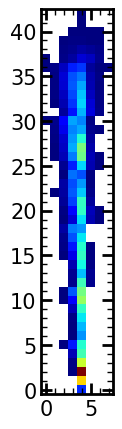

In [38]:
# list_muonlabels = [10, 15, 74, 91, 92, 112, 133, 176, 196, 256]  # Segunda revisión (están arriba)
# list_muonlabels = [10, 15, 91, 112, 176, 196, 256] # Tercera revisión (con misma gain = 215)

n_label = 0
display(DF_muons.iloc[[n_label]])

figure , axs = plt.subplots(1,1,figsize=[5,5])
axs.imshow(list_mask_rot[n_label],  cmap = ColorMap)  # 77, 1911, 2381, 2930 indices para path con elip 0.85, Sol 0.7
plt.show()


Numper of rows:  43
Long of line:  5


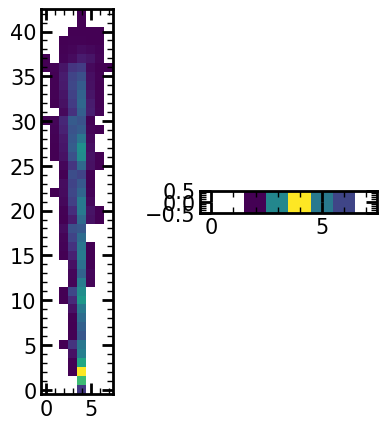

In [41]:
figure , axs = plt.subplots(1,2,figsize=[5,5])

label_muon = 0
label_line = 40
muon = list_mask_rot[label_muon]
print('Numper of rows: ', muon.shape[0])
line = list_mask_rot[label_muon][label_line - 1:label_line][0]

n_longline = 0
for pixel in line:
    if pixel != 0:
        # print(pixel)
        n_longline += 1

print('Long of line: ', n_longline)

axs[0].imshow(list_mask_rot[label_muon])
axs[1].imshow(list_mask_rot[label_muon][label_line - 1:label_line])
plt.show()

In [9]:
list_index_long_muons = []
extension = 1

for index in range(0, len(list_mask_rot)):
    size_x = list_mask_rot[index].shape[1]
    size_y = list_mask_rot[index].shape[0]
    if size_y > 50:
        # print(size_x, size_y)
        list_index_long_muons.append(index)

# print(list_index_long_muons)+
print('Muones largos detectados: ', len(list_index_long_muons))
print('Indices: ', list_index_long_muons)

Muones largos detectados:  52
Indices:  [1, 9, 10, 15, 16, 17, 22, 32, 38, 44, 49, 50, 54, 68, 73, 86, 87, 88, 95, 96, 104, 106, 107, 114, 117, 137, 144, 154, 155, 158, 159, 160, 169, 172, 180, 183, 186, 196, 197, 206, 207, 213, 214, 219, 221, 222, 228, 242, 243, 250, 252, 257]


### Perfil Energético

Number of rows:  51


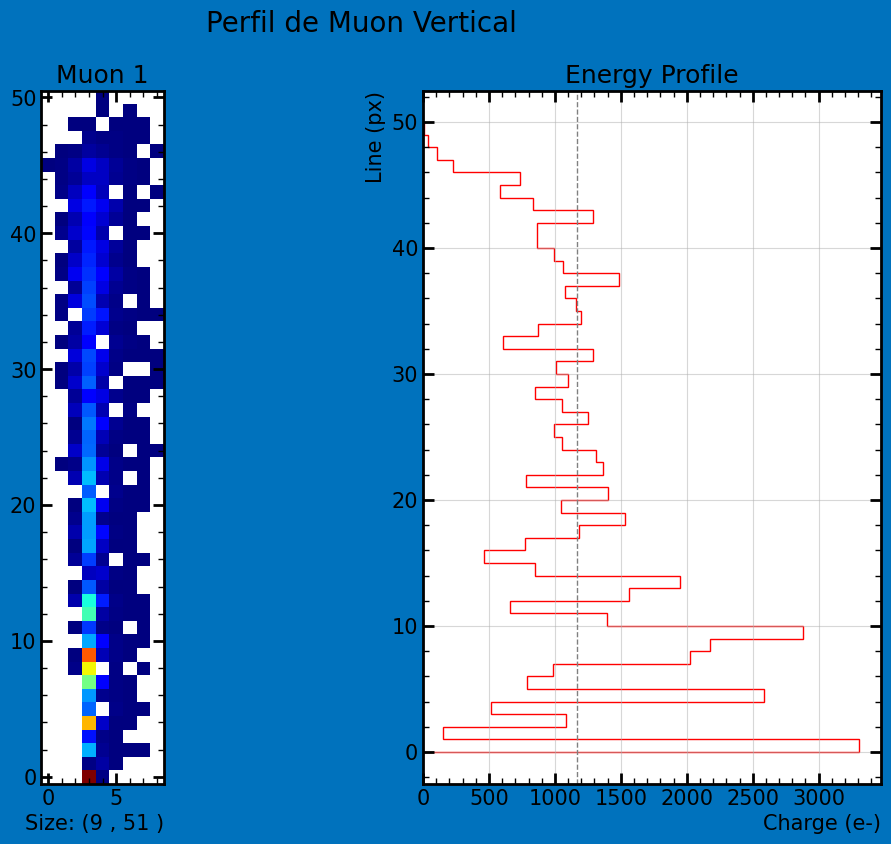

In [43]:
# list_muonlabels = [10, 15, 74, 91, 92, 112, 133, 176, 196, 256]  # Segunda revisión (están arriba)
muon_label = 1  # Se coloca directamente el label del evento

Delta_inicial = 0
Delta_final = 0
extension = 1

fig, axs = plt.subplots(ncols=2, nrows=1, figsize = [13,9], facecolor = [0, 0.4470, 0.7410])
fig.suptitle('Perfil de Muon Vertical', y = 0.97, size = 20)

# for event in matrix_ext_4_vertical[num:num + 1]:

# event = check_flip_vertical_muon(dict= data_histogram, label_muon=muon_label, Delta_in=Delta_inicial, Delta_fin=Delta_final, extension=extension)
event = list_mask_rot[muon_label]
# plt.imshow(event)

size_x = event.shape[1] # tamaño en x
size_y = event.shape[0] # tamaño en y
# print(event.sum())


### ==== Método con los labels de ndimage === ###
# label_verticalMuon, nlabels_verticalMuon = ndimage.label(event,structure=[[0,0,0],[1,1,1],[0,0,0]])

# charge_verticalMuon = []
# for lable_line in range(Delta_inicial, nlabels_verticalMuon - Delta_final):
    # line = label_verticalMuon == lable_line
    # loc = ndimage.find_objects(label_verticalMuon == lable_line)[0]
    # mask_35 = np.invert(label_verticalMuon == lable_line)
    # data_mask = ma.masked_array(event[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop], mask_35[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop])
    # # print(len(data_mask[0]))
    # charge = data_mask.sum()
    # print('Charge line ' + str(lable_line) + ': ', charge, ' , label_line: ', lable_line)
    # # print(charge)
    # mean_charge = data_mask.mean()

    # charge_verticalMuon.append(charge)
    # # print(charge)

### ========================================== ###



print('Number of rows: ', event.shape[0])
charge_verticalMuon = []
for index in range(1, size_y):
    line = event[index - 1:index][0]
    charge = line.sum()/0.0036
    charge_verticalMuon.append(charge)

## Linea inferior ##
# line_inf = [size_x]
# axs[0].imshow(data_mask)
# print(charge_verticalMuon[0], charge_verticalMuon[-1])
        
# cmap = 'plasma'
axs[0].imshow(event, cmap = ColorMap)#, origin='upper')
axs[0].set_title('Muon ' + str(muon_label))
axs[0].set_xlabel('Size: (' + str(size_x) + ' , ' + str(size_y) + ' )')
# x0bar = fig.colorbar(x0, ax=axs[0])

axs[1].stairs(charge_verticalMuon, np.arange(0,len(charge_verticalMuon)+1),  orientation='horizontal', color = 'r')#,  hatch = '////')
axs[1].axvline(4.2/0.0036, 0, size_y+2, linestyle='--', color='gray')
# axs[1].vlines(x = mean_charge, ymin = 0, ymax = len(event) - 1, color = 'k', label = 'Mean Charge \n' + str(mean_charge))
# axs[1].set_xlabel('Charge (KeV)')
axs[1].set_xlabel('Charge (e-)')
axs[1].set_ylabel('Line (px)')
# axs[1].set_ylim(0,len(event) - 1 )
axs[1].set_title('Energy Profile')
# axs[1].legend()
axs[1].grid()
plt.show()

In [11]:
list_muonlabels = [10, 15, 74, 91, 92, 112, 133, 176, 196, 256]  # Segunda revisión (están arriba)

for muon_label in list_muonlabels:
    event = list_mask_rot[muon_label]
    print('Muon: ', muon_label, ', Shape (X, Y): ', event.shape[1], event.shape[0])

Muon:  10 , Shape (X, Y):  12 82
Muon:  15 , Shape (X, Y):  11 54
Muon:  74 , Shape (X, Y):  8 31
Muon:  91 , Shape (X, Y):  9 36
Muon:  92 , Shape (X, Y):  10 36
Muon:  112 , Shape (X, Y):  9 40
Muon:  133 , Shape (X, Y):  8 27
Muon:  176 , Shape (X, Y):  8 41
Muon:  196 , Shape (X, Y):  8 74
Muon:  256 , Shape (X, Y):  12 43


Number of rows:  38


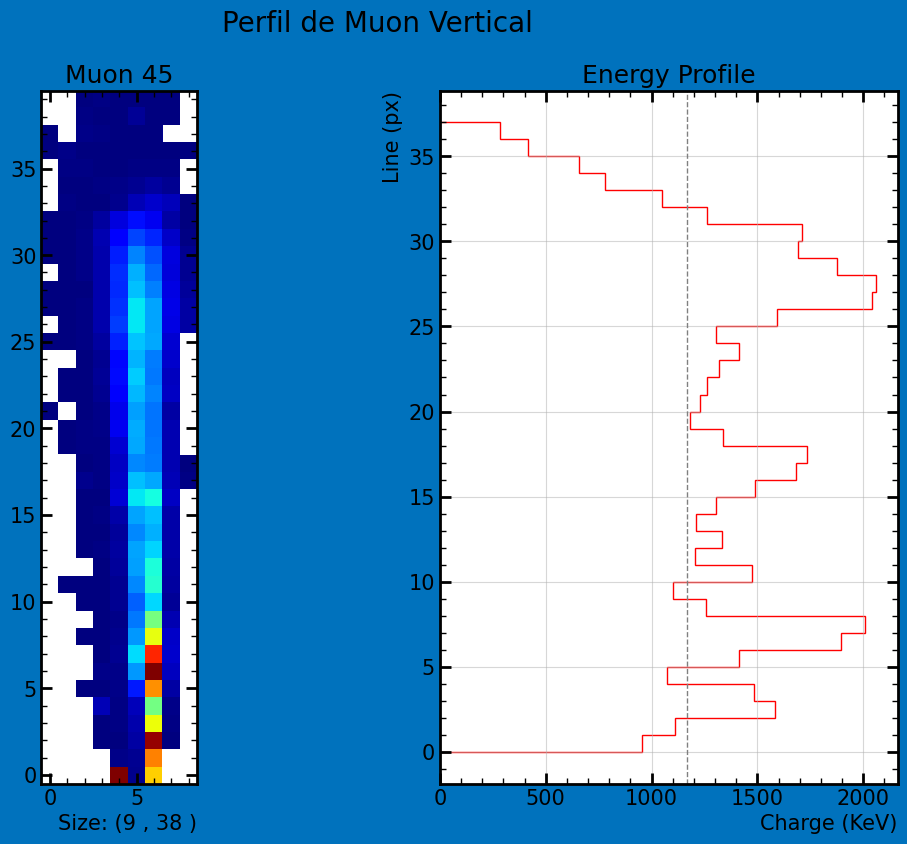

In [12]:
# list_muonlabels = [0, 10, 15, 16, 35, 36, 44, 47, 49, 55]
list_muonlabels = [0, 45,55,112]


muon_label = 45  # Se coloca directamente el label del evento
muon_label2 = 0
muon_label3 = 55
muon_label4 = 112

Delta_inicial = 0
Delta_final = 0
extension = 1

fig, axs = plt.subplots(ncols=2, nrows=1, figsize = [13,9], facecolor = [0, 0.4470, 0.7410])
fig.suptitle('Perfil de Muon Vertical', y = 0.97, size = 20)

# for event in matrix_ext_4_vertical[num:num + 1]:

# event = check_flip_vertical_muon(dict= data_histogram, label_muon=muon_label, Delta_in=Delta_inicial, Delta_fin=Delta_final, extension=extension)
event = list_mask_rot[muon_label]
event2 = list_mask_rot[muon_label2]
event3 = list_mask_rot[muon_label3]
event4 = list_mask_rot[muon_label4]
# plt.imshow(event)

size_x = event.shape[1] # tamaño en x
size_y = event.shape[0] # tamaño en y
# print(event.sum())


print('Number of rows: ', event.shape[0])
charge_verticalMuon = []
for index in range(1, size_y):
    line = event[index - 1:index][0]
    line2 = event2[index - 1:index][0]
    line3 = event3[index - 1:index][0]
    line4 = event4[index - 1:index][0]

    charge = line.sum()
    charge2 = line2.sum()
    charge3 = line3.sum()
    charge4 = line4.sum()

    mean_charge = (charge + charge2 + charge3 + charge4)/4

    charge_verticalMuon.append(mean_charge/0.0036)

## Linea inferior ##
# line_inf = [size_x]
# axs[0].imshow(data_mask)
# print(charge_verticalMuon[0], charge_verticalMuon[-1])
        
# cmap = 'plasma'
# axs[0].imshow(event[0:38, 0:8] + event2[:38, :8] + event3[:38, :8] + event4[:38, :8])#+ event3 + event4, cmap = ColorMap)#, origin='upper')

axs[0].imshow(event, cmap = ColorMap)#, origin='upper')
axs[0].imshow(event2, cmap = ColorMap)#, origin='upper')
axs[0].imshow(event3, cmap = ColorMap)#, origin='upper')
axs[0].imshow(event4, cmap = ColorMap)#, origin='upper')


axs[0].set_title('Muon ' + str(muon_label))
axs[0].set_xlabel('Size: (' + str(size_x) + ' , ' + str(size_y) + ' )')
# x0bar = fig.colorbar(x0, ax=axs[0])

axs[1].stairs(charge_verticalMuon, np.arange(0,len(charge_verticalMuon)+1),  orientation='horizontal', color = 'r')#,  hatch = '////')
axs[1].axvline(4.2/0.0036, 0, size_y+2, linestyle='--', color='gray')
# axs[1].vlines(x = mean_charge, ymin = 0, ymax = len(event) - 1, color = 'k', label = 'Mean Charge \n' + str(mean_charge))
axs[1].set_xlabel('Charge (KeV)')
axs[1].set_ylabel('Line (px)')
# axs[1].set_ylim(0,len(event) - 1 )
axs[1].set_title('Energy Profile')
# axs[1].legend()
axs[1].grid()
plt.show()

### Modelo de Difusión

In [44]:
CCD_depth = 725 # micras
Delta_inicial = 3    # px
Delta_final = 6     # px
Bins = 50

extension = 1
label_muon = 1
lable_line = 10
img_sigma = 0.0003  # KeV 
# print(img_sigma)

## Se checa si el muon tiene la orientación correcta
event = list_mask_rot[label_muon]
size_x = event.shape[1]
size_y = event.shape[0]

# lines = 0
Longitud_XY = size_y 
Longitud_linea = size_x

Z_inicial = (Delta_inicial * CCD_depth) / (Longitud_XY - Delta_final)


line = event[lable_line - 1:lable_line][0]
Carga_renglon = line.sum()
Mean_carga = np.mean(line)


Mean_in  = 0
var = 0
carga_cuadrada = 0

### Se calcula el X promedio ##
for pixel in np.arange(0, Longitud_linea, 1):
    if line[pixel]:
        element_pixel = (pixel * line[pixel]) / Carga_renglon
        Mean_in = Mean_in + element_pixel
    else:
        element_pixel = 0
    
    Mean_in = Mean_in + element_pixel

## Calcula la suma de las cargas al cuadrado ##
for pixel in np.arange(0, Longitud_linea, 1):
    if line[pixel]:
        element_pixel = line[pixel]**2
    else:
        element_pixel = 0

    carga_cuadrada = carga_cuadrada + element_pixel 

Mean_carga_cuadrada = carga_cuadrada/Longitud_linea

### Se calcula la varianza ##
for pixel in np.arange(0, Longitud_linea, 1):
    element_pixel =(1 / (Longitud_linea - 1)) * (pixel - Mean_in)**2
    var = var + element_pixel  ### COreggir la varianza con otro estimados

### Se corrige la varianza con la carga ###
var_true = var * (Mean_carga_cuadrada / (Mean_carga**2))

### Se calcula la sigma ###
sigma_in = np.sqrt(var)
# sigma_in = np.sqrt(var_true)


##Se crea un arreglo para usarlo en el plot de los datos, y se realiza el juste ##
list_xlabel = np.arange(0.5, len(line), 1)

# list_xlabel_long = np.linspace(-Longitud_linea + int(Longitud_linea/2) , Longitud_linea + int(Longitud_linea/2), Longitud_linea)

# popt, pcov = curve_fit(gaussian, list_xlabel, data_mask[0], maxfev=100000, p0 = [8000, Mean_in, sigma_in])		# Fit histogram with gaussian

print('Lonitud de la linea: ', len(line.flatten()))

## Ajuste gaussiano con ROOT ##
fgaus2 = TF1("fgauss","gaus",  0,  len(line.flatten()), 3) # TF1("nombre", "funcion escrita como en root", min, max, #parametros)
h3=TH1F("histogram", "Distribution of Line", len(line.flatten()) + 1, 0,  len(line.flatten()) )

for index in range(0, len(line)):
    if line[index] != 0:
        # print(index, line[index])
        h3.SetBinContent( index + 1, line[index])
        # h3.SetBinError(index + 1, 0.001)
        #print(pixel_value)

fgaus2.SetParameters(np.max(line),Mean_in,sigma_in) # Establecer parametros iniciales del fit, de manera visual es posible determinarlos como una primera aproximacion
h3.Fit(fgaus2, "RQN")

fit_const = fgaus2.GetParameters()[0]
fit_mean = fgaus2.GetParameters()[1]
fit_sigma = fgaus2.GetParameters()[2]
print('Sigma fit: ', fit_sigma, end='\n\n')

c3=TCanvas()

h3.Draw()
c3.Draw()
fgaus2.Draw("same")
# gStyle.SetOptFit(1100)
# gStyle.SetPadGridX (True)



# plt.show()

Lonitud de la linea:  9
Sigma fit:  0.30156153669763414



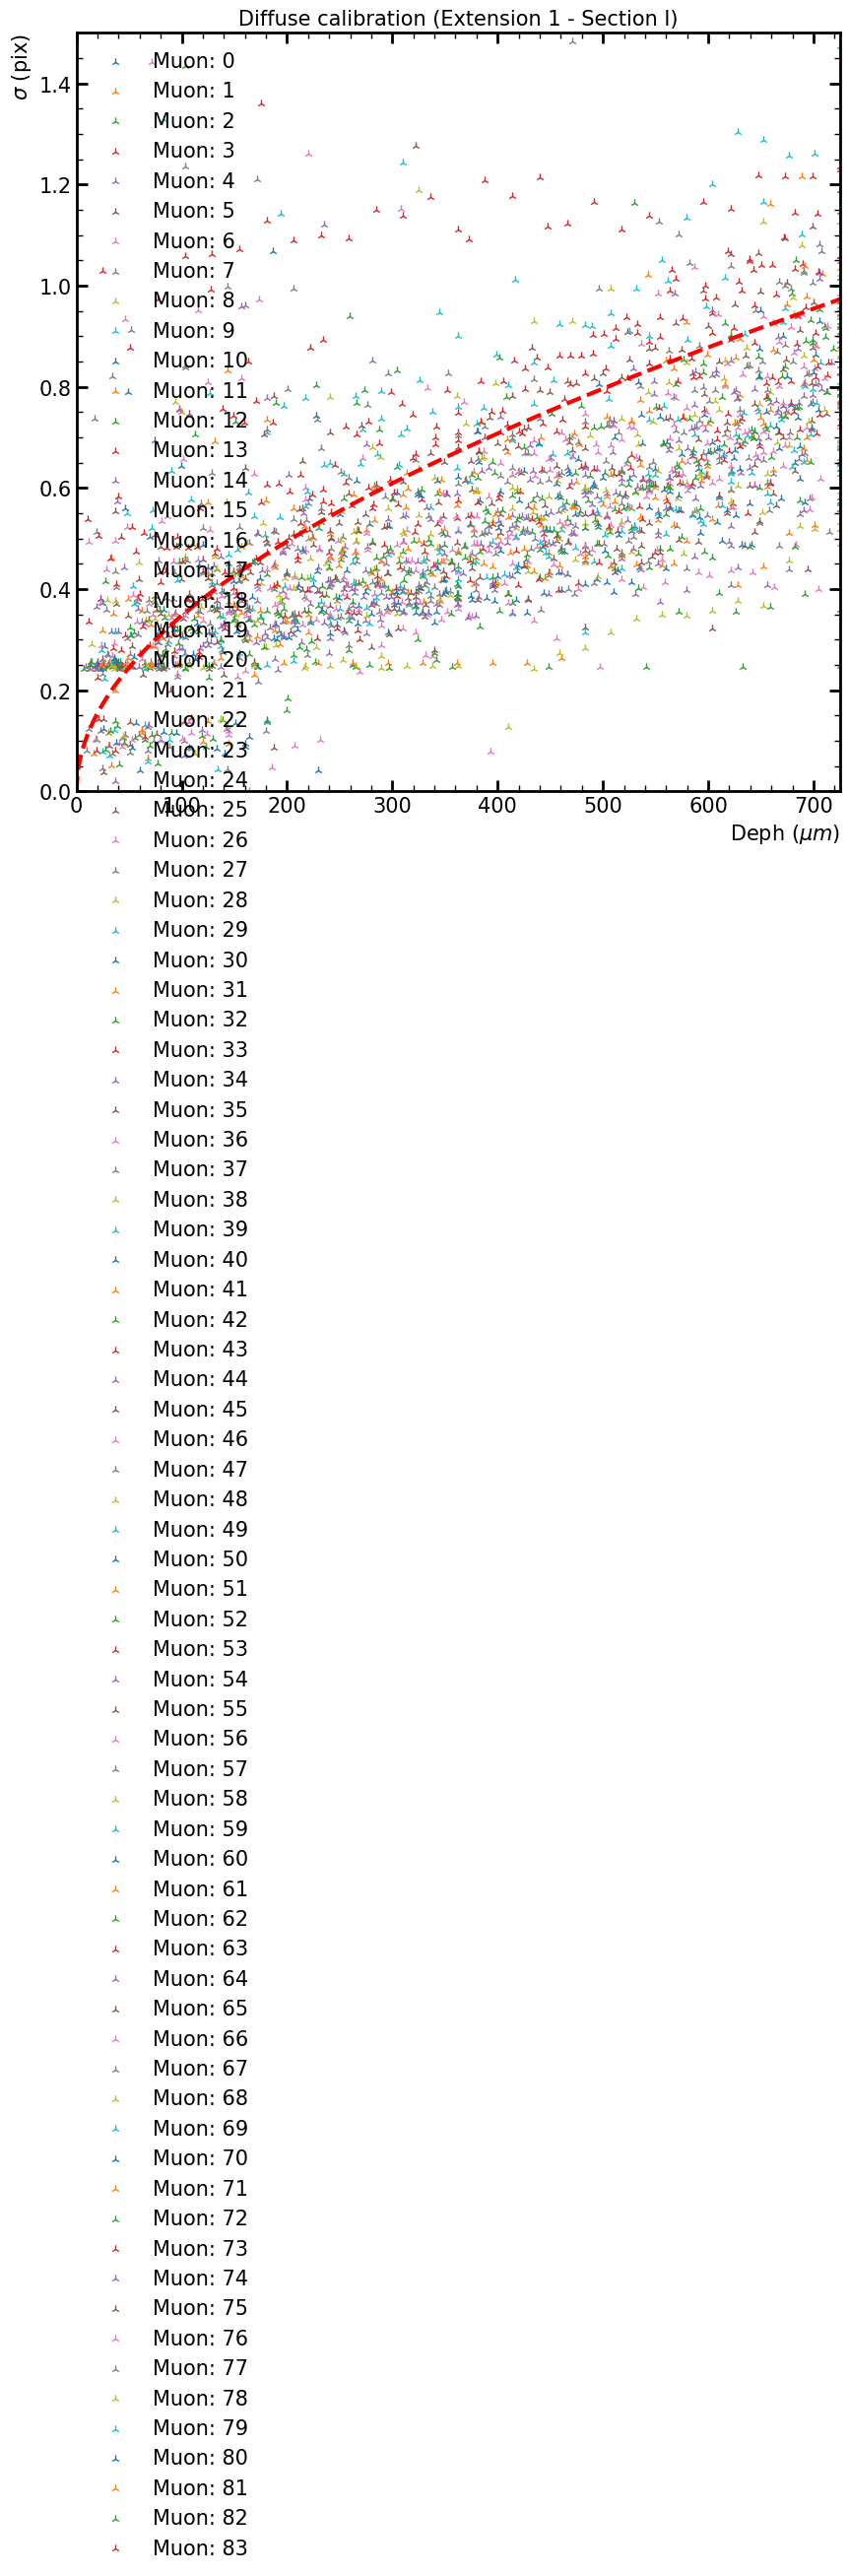

In [46]:
CCD_depth = 725 # micras
Delta_inicial = 1    # px
Delta_final = 6     # px
Bins = 50

extension = 1
label_muon = 1
img_sigma = 0.0008  # KeV 
# print(img_sigma)
fig, axs_all = plt.subplots(figsize = [10,10])

list_muonlabels = []
for index in range(0, len(list_mask_rot)):
    list_muonlabels.append(index)


# list_muonlabels = [10, 15, 30, 39, 47, 61, 74, 77, 91, 92, 112, 117, 133, 157, 176, 184, 189, 196, 213, 214, 231, 256]  # Primeros sacados a ojo (están abajo)
# list_muonlabels = [0, 1,2,3]

 
# list_muonlabels = [10, 15, 30, 39, 47, 61, 74, 77, 91, 92, 112, 117, 133, 157, 176, 184, 189, 196, 213, 214, 231, 256]  # Primeros sacados a ojo (están arriba)
# list_muonlabels = [10, 74, 91, 92, 112, 133, 176, 196, 256]  # Segunda revisión (están arriba)
# list_muonlabels = [10, 15, 91, 112, 176, 196, 256]  # Tercera revisión con, mas o menos, misma gain (están arriba)



# list_muonlabels = [256, 257, 258]



for label_muon in list_muonlabels: 
    event = list_mask_rot[label_muon]
    size_x = event.shape[1]
    size_y = event.shape[0]

    # lines = 0
    Longitud_XY = size_y 
    Z_inicial = (Delta_inicial * CCD_depth) / (Longitud_XY - Delta_final)
    # print('Muon: ', label_muon, ', Shape (X, Y): ', event.shape[1], event.shape[0])

    list_fitsigmas = []
    for lable_line in range(Delta_inicial, size_y - Delta_final):
        line = event[lable_line - 1:lable_line][0]
        Carga_renglon = line.sum()
        Mean_carga = np.mean(line)
        Longitud_linea = len(line)


        Mean_in  = 0
        var = 0
        carga_cuadrada = 0

        ### Se calcula el X promedio ##
        for pixel in range(0, Longitud_linea):
            if line[pixel]:
                element_pixel = (pixel * line[pixel]) / Carga_renglon
                Mean_in = Mean_in + element_pixel
            else:
                element_pixel = 0
            
            Mean_in = Mean_in + element_pixel

        ## Calcula la suma de las cargas al cuadrado ##
        for pixel in np.arange(0, Longitud_linea, 1):
            if line[pixel]:
                element_pixel = line[pixel]**2
            else:
                element_pixel = 0

            carga_cuadrada = carga_cuadrada + element_pixel 

        Mean_carga_cuadrada = carga_cuadrada/Longitud_linea

        ### Se calcula la varianza ##
        for pixel in np.arange(0, Longitud_linea, 1):
            if line[pixel]:
                element_pixel =(1 / (Longitud_linea - 1)) * (pixel - Mean_in)**2 * line[pixel]
                var = var + element_pixel  ### COreggir la varianza con otro estimados

        ### Se corrige la varianza con la carga ###
        # var_true = var * (Mean_carga_cuadrada / (Mean_carga**2))
        var_true = var / Carga_renglon

        ### Se calcula la sigma ###
        sigma_in = np.sqrt(var)
        # print(sigma_in)
        # sigma_in = np.sqrt(var_true)


        ##Se crea un arreglo para usarlo en el plot de los datos, y se realiza el juste ##
        list_xlabel = np.arange(0.5, len(line), 1)


        ## Ajuste gaussiano con ROOT ##
        fgaus2 = TF1("fgauss","gaus",  0,  len(line.flatten()), 3) # TF1("nombre", "funcion escrita como en root", min, max, #parametros)
        h3=TH1F("histogram", "Distribution of Line", len(line.flatten()) + 1, 0,  len(line.flatten()) )

        for index in range(0, len(line)):
            if line[index] != 0:
                # print(index, line[index])
                h3.SetBinContent( index + 1, line[index])
                # h3.SetBinError(index + 1, 0.001)
                #print(pixel_value)

        fgaus2.SetParameters(np.max(line),Mean_in,sigma_in) # Establecer parametros iniciales del fit, de manera visual es posible determinarlos como una primera aproximacion
        h3.Fit(fgaus2, "RQN")

        fit_const = fgaus2.GetParameters()[0]
        fit_mean = fgaus2.GetParameters()[1]
        fit_sigma = fgaus2.GetParameters()[2]


        # fit_sigma = sigma_in
        # print('Sigma fit: ', fit_sigma)
        list_fitsigmas.append(fit_sigma)

        del h3

    list_deep = []
    list_xlabel_sigmas = np.linspace(Z_inicial, CCD_depth, len(list_fitsigmas))
    for deep in list_xlabel_sigmas:
        list_deep.append(deep)

    axs_all.scatter(list_deep, list_fitsigmas, marker='2', label = 'Muon: ' + str(label_muon))


def diffution_curve(z, alpha, beta):
    return np.sqrt(np.abs(alpha * np.log(1 - (beta * z))))

fit_range = np.arange(0, 900)

axs_all.plot(fit_range, diffution_curve(fit_range, alpha=-5.19, beta=0.00023), '--r', linewidth = 3)

axs_all.set_title('Diffuse calibration (Extension 1 - Section I)', size = 15)#, y=0.92)}
axs_all.set_ylabel(r'$\sigma$ (pix)')
axs_all.set_xlabel(r'Deph ($\mu m$)')
axs_all.set_ylim(0, 1.5)
axs_all.set_xlim(0, 725)
axs_all.legend()
axs_all.grid
plt.show()